# Chap3. wor2vec
## 3.4 CBOW 모델 구현

앞 절에서 CBOW모델의 학습을 위해 데이터를 준비했었다. CBOW 모델 학습을 위해 데이터를 다시 불러보자!

In [1]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)

# contexts와 target을 one-hot vector로 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [2]:
print('target: ', target)
print('contexts: ', contexts)

# 원-핫 베겉로 target과 context데이터가 생성된 것을 확인할 수 있다.

target:  [[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
contexts:  [[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [3]:
contexts.shape

(6, 2, 7)

In [4]:
contexts[:, 0]  

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0]])

In [5]:
print(contexts[0, 0])
print(contexts[1, 0])
print(contexts[2, 0])
print(contexts[3, 0])
print(contexts[4, 0])
print(contexts[5, 0])

[1 0 0 0 0 0 0]
[0 1 0 0 0 0 0]
[0 0 1 0 0 0 0]
[0 0 0 1 0 0 0]
[0 0 0 0 1 0 0]
[0 1 0 0 0 0 0]


헷갈릴때는 이렇게 print를 찍고, 어느부분에서 혼란이 오는지 파악하는 것도 하나의 방법일까?

In [6]:
contexts[:, 0].shape

(6, 7)

In [7]:
contexts[:, 1]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]])

SimpleCBOW라는 이름으로 CBOW모델을 구현해보자.

In [8]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):  # 초기화 메서드의 인수로 vocab_size(어휘 수)와 은닉층의 뉴런 수(hidden_size)를 받는다.
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')  # 무작위 Weight 초기화, 타입은 float 32비트로 만들어준다.
        W_out = 0.01 * np.random.randn(H, V).astype('f')  # W_in (V, H), W_out (H, V)
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)  # 입력값과 가중치값의 곱을 구해준다.
        self.in_layer1 = MatMul(W_in)  # 입력에서 사용하는 MatMul 계층의 수는 입력에 사용되는 단어의 수만큼 만들어야 한다.
                                       # 윈도우의 크기가 2이므로 2개의 MatMul계층을 만들어준다.
                                       # 윈도우의 크기가 n이라면 n개의 MatMul계층을 만들어주는 것이다.
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모아준다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []  # 신경망에서 사용되는 매개변수와 기울기를 인스턴스 변수인 params와 grads 리스트에 각각 모아둔다.
        
        for layer in layers:  
            self.params += layer.params
            self.grads += layer.grads        
        
        # 인스턴스 변수에 단어의 분산 표현을 저장
        self.word_vecs = W_in
        
    # 순전파 forward 메서드 구현 
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])  # contexts는 3차원 배열인데...
                                                     # contexts[:, 0]
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    # 역전파
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)  # descent_softmax
        da = self.out_layer.backward(ds)     # descent_matmul
        da *= 0.5
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)
        return None

📌 &lt;To-do&gt;<br>

20.03.25.Wed. pm 3:12
<br>
* common trainer
* common optimizer
* SimpleCBOW.py

코드를 그저 따라쳤던게 아닌가 다시한번 냉정하게 생각해보자...<br>
내가 지금 구현하고 있는 모델이 어떤 구조를 가지고 있으며 해당 부분들이 코드로 어떻게 구현되는지 제대로 알고 넘어갈 수 있도록 하자.

📌 Check Point<br>
CBOW 모델의 신경망 구성을 다시 한번 체크하기<br>
신경망을 코드로 구현하는 과정 꼼꼼하게 짚고 넘어가기

### 3.4.1 학습 코드 구현
학습을 수행 하는데 있어서 Trainer 클래스를 사용한다.<br>
"1장에서 설명한 Trainer 클래스를 사용한다."<br>
안타깝지만... 기억속에 없다...

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

C:\Users\stevelee\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\stevelee\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\stevelee\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\stevelee\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\stevelee\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\stevelee\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49892 

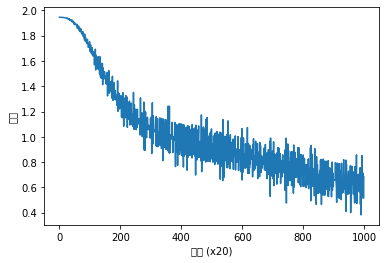

In [11]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
# from simple_cbow import SimpleCBOW   # 위에서 구현한 SimpleCBOW 클래스를 사용한다.
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000  # 이참에 batch_size와 epoch의 차이에 대해서도 제대로 짚고 넘어가자!!

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()



Done!

학습이 거듭할수록 손실이 줄어드는 것을 알 수 있다.

입력 측 MatMul 계층의 가중치를 꺼내 실제 내용을 확인해보자.<br>
입력 측 MatMul 계층의 가중치는 인스턴스변수 word_vecs에 저장되어 있으니, 앞의 코드 바로 뒤에 다음 코드를 추가한다.

In [13]:
word_vecs = model.word_vecs  # shape: (V, H)  Vocab_size, Hidden_layer_size(여기서는 5)
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.1246825  1.3285567  1.0446517 -1.1392537  1.11887  ]
say [-1.2467808  -1.2030725  -1.2634215   0.81029844 -1.2427245 ]
goodbye [ 0.77086127  0.49458748  0.86777127 -0.91842395  0.7753145 ]
and [-1.1736779   0.36670497 -0.93621457  1.9704143  -0.7761208 ]
i [ 0.7847343   0.46178705  0.8781177  -0.9041494   0.81754   ]
hello [ 1.118274   1.3379145  1.0289601 -1.1385485  1.1093373]
. [-0.93588614 -1.6390208  -1.2411219  -1.3929871  -1.3882316 ]


you라는 단어를 벡터 [ 1.1246825  1.3285567  1.0446517 -1.1392537  1.11887  ]로 표현할 수 있구나.<br>
이하 마찬가지!!

**마침내 단어를 밀집 벡터로 표현할 수 있게 되었다**
* 밀집벡터
    * 단어의 분산표현이다.
    * 이 분산 표현은 '단어의 의미'를 잘 파악한 벡터표현으로 기대할 수 있다.
* 개선사항
    * 데이터가 너무 작기 때문에(말뭉치가 작아요) 좋은 결과를 얻을 수 없다.
    * 현 시점의 CBOW모델은 처리 효율면에서 몇 가지 문제가 있다.
    * 4장에서는 현재의 단순한 CBOW모델을 개선하여 '진짜' CBOW모델을 구현할 것이다!!